In [23]:
from matplotlib.pyplot import *
import numpy as np
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
import sklearn
%load_ext autoreload
from skimage import feature
import scipy
from skimage.filters import gabor
from skimage.filters import threshold_otsu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Funções Base

In [2]:
def find_index(wavelenghts,w):
    return np.argmin(np.abs(wavelenghts - w))

In [3]:
def Raman_data_loader(filename):

    with h5py.File(filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number//Ny), int(spot_number%Ny)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties

In [4]:
def read_data_map(file):
    hf = h5py.File(file, 'r')
    spectrums = np.array(hf.get('intensities'))
    positions = np.array(hf.get('position'))
    wavelengths = np.array(hf.get('wavelengths'))
    positions = np.delete(positions, 0, 0)
    spectrums = np.delete(spectrums, 0, 0)
    x = positions[:, 0]
    y = positions[:, 1]
    xy = np.lexsort((y, x))

    hf.close()
    return spectrums[xy], wavelengths, positions

In [5]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter = 10):
    L = len(y)
    D = sparse.diags([1, -2, 1],[0, -1, -2], shape = (L, L - 2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [6]:
def read_ref(mineral):
    df = pd.read_csv(mineral + '_raman.txt',header=13,names=['wavenumber','int'],skipfooter=4,engine='python' )
    return np.array(df['wavenumber']),np.array(df['int'])

# 1.0 Raman

In [7]:
folder='C:/Users/Joana/Documents/Doutoramento/1 ano/spectral imaging/imaging_clustering/dados/'
filename = "2023913_1110.h5"
spectrum_raman, wavelengths_raman, exp_properties = Raman_data_loader(folder+filename)

lam = 1e2
p = 1e-1
    
pro_data = 1*spectrum_raman
for i in tqdm(range(0, pro_data.shape[0])):
    for j in range(0, pro_data.shape[1]):
        spec = 1 * pro_data[i, j, :]
        pro_data[i, j, :] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)

pro_data_norm=pro_data.copy()
for i in range(0,pro_data.shape[0]):
    for j in range(0,pro_data.shape[1]):
        spec = 1 * pro_data[i,j, :]
        sum_spec=np.sum(spec)
        pro_data_norm[i,j,:]=spec/sum_spec
offset_l = 31
offset_m = 328

mask = pro_data_norm[:, :, offset_l:offset_m].reshape(pro_data.shape[0]*pro_data.shape[1], -1)

threshold = 1.27e-9

mask_offset = np.array(mask)
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in range(mask_offset.shape[-1])])


offset_l = 31
offset_m = 328
wavelengths_raman.shape
wavelengths=wavelengths_raman[offset_l:offset_m]

minerals = {
    
    'Albite':[508.1],
    'Background':[733.1],
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5]}

mineral_list = list(minerals.keys())


100%|██████████| 250/250 [07:05<00:00,  1.70s/it]


## Edge detector

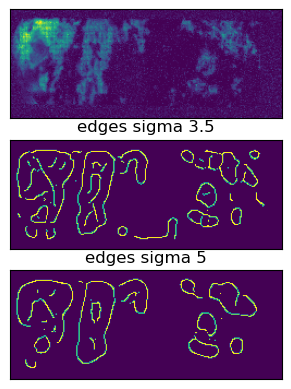

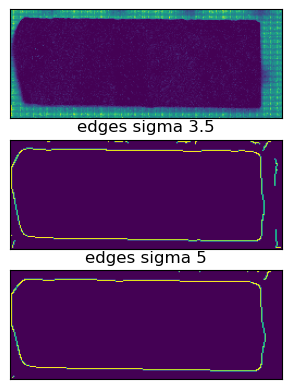

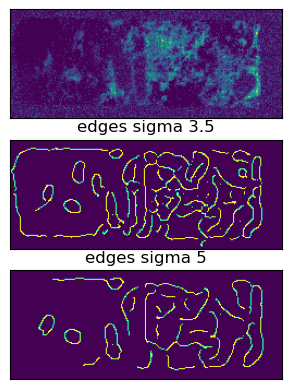

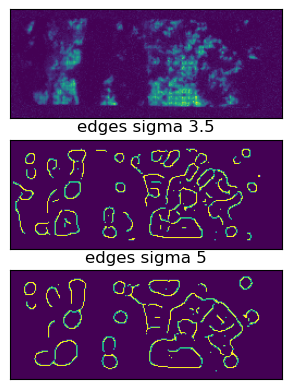

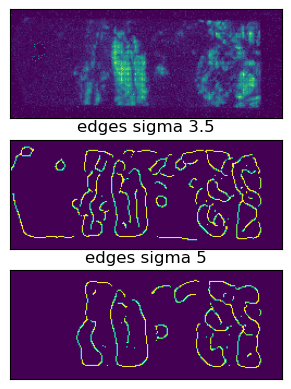

In [8]:

mask_maps=mask_t.reshape(-1,pro_data_norm.shape[0],pro_data_norm.shape[1])
for i in mineral_list:
    wavenumb=minerals[i]
    current_map=mask_maps[find_index(wavelengths,wavenumb),:,:]*255

    fig,ax=subplots(3)
    ax[0].imshow(current_map.T)

    edges1 = feature.canny(current_map,sigma=3.5)
    edges2 = feature.canny(current_map, sigma=5)
    ax[1].imshow(edges1.T)
    ax[1].set_title('edges sigma 3.5')

    ax[2].imshow(edges2.T)
    ax[2].set_title('edges sigma 5')
    for j in range(3):
        ax[j].set_xticks([])
        ax[j].set_yticks([])

    plt.show()

## Texture Analysis

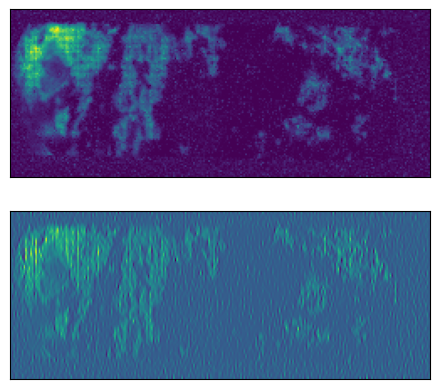

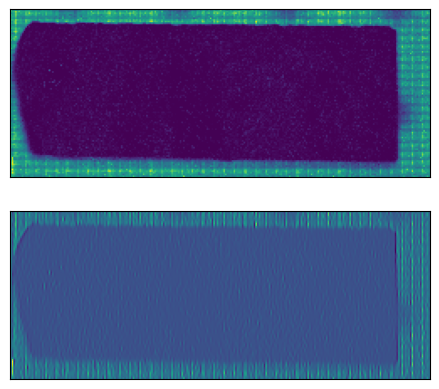

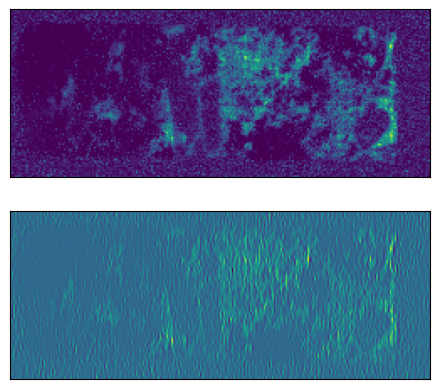

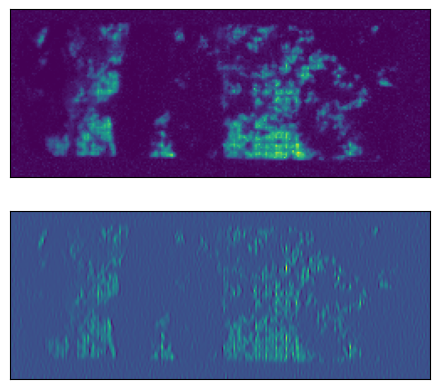

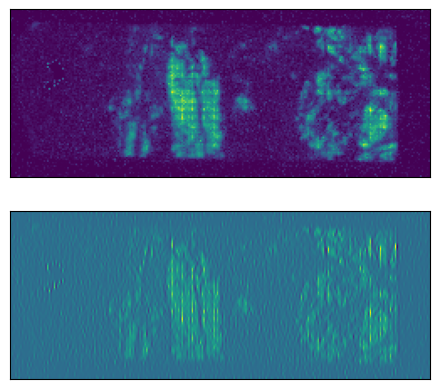

In [9]:
from skimage.filters import gabor
for i in mineral_list:
    wavenumb=minerals[i]
    current_map=mask_maps[find_index(wavelengths,wavenumb),:,:]*255

    fig,ax=subplots(2)
    ax[0].imshow(current_map.T)
    filt_real, filt_imag = gabor(current_map.T, frequency=0.6) #lower f, more sensitivty to detail
    #f<0.6 começa a perder os detalhes dos mapas
    ax[1].imshow(filt_real)
    for j in range(2):
        ax[j].set_xticks([])
        ax[j].set_yticks([])

    plt.show()

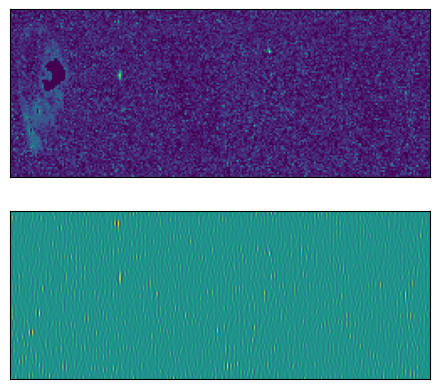

In [10]:
#on a noise map

current_map=mask_maps[150,:,:]*255

fig,ax=subplots(2)
ax[0].imshow(current_map.T)
filt_real, filt_imag = gabor(current_map.T, frequency=0.5) #lower f, more sensitivty to detail
#f>=1 fica igual a imagem original
ax[1].imshow(filt_real)
for j in range(2):
    ax[j].set_xticks([])
    ax[j].set_yticks([])

plt.show()

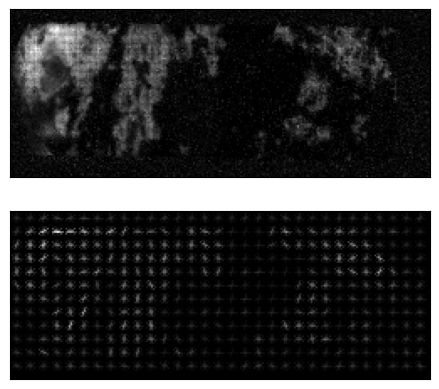

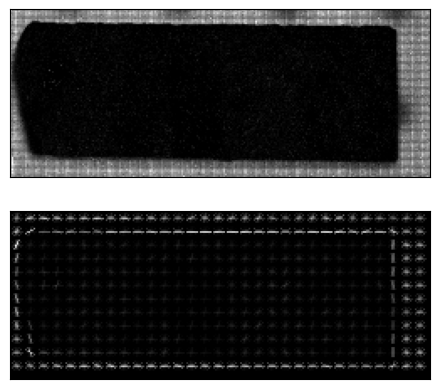

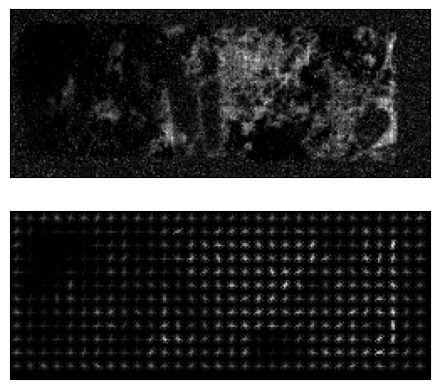

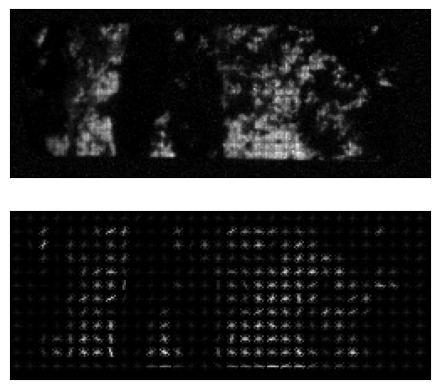

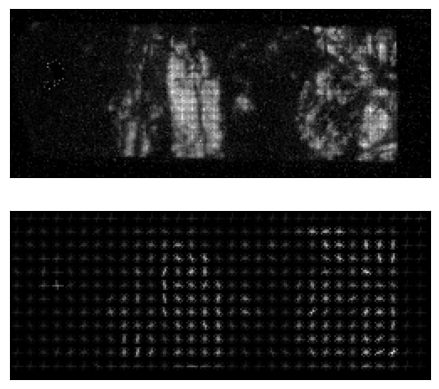

In [11]:
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

# Iterate over your mineral list
for i in mineral_list:
    wavenumb = minerals[i]
    current_map = mask_maps[find_index(wavelengths, wavenumb), :, :] * 255

    # Compute HOG features and the HOG image
    features, hog_image = hog(
        current_map.T, 
        orientations=9, 
        pixels_per_cell=(8, 8), 
        cells_per_block=(2, 2), 
        block_norm='L2-Hys', 
        visualize=True, 
        feature_vector=True
    )

    # Plot the original and HOG image
    fig, ax = plt.subplots(2)
    ax[0].imshow(current_map.T, cmap='gray')
    ax[1].imshow(hog_image, cmap='gray')

    for j in range(2):
        ax[j].set_xticks([])
        ax[j].set_yticks([])

    plt.show()


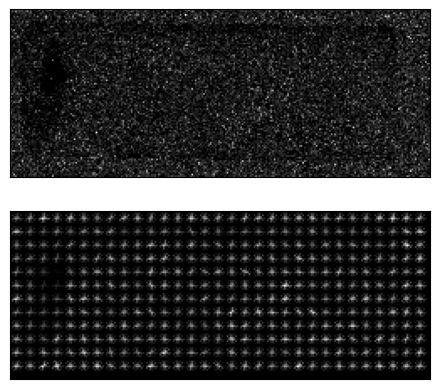

In [12]:
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

# Load your noise map
current_map = mask_maps[296, :, :] * 255

# Compute HOG features and the HOG image
features, hog_image = hog(
    current_map.T, 
    orientations=9, 
    pixels_per_cell=(8, 8), 
    cells_per_block=(2, 2), 
    block_norm='L2-Hys', 
    visualize=True, 
    feature_vector=True
)

# Plot the original noise map and the HOG visualization
fig, ax = plt.subplots(2)
ax[0].imshow(current_map.T, cmap='gray')
ax[1].imshow(hog_image, cmap='gray')

# Remove axis ticks
for j in range(2):
    ax[j].set_xticks([])
    ax[j].set_yticks([])

plt.show()


# 2.0 LIBS

In [13]:
filename = folder+"PetalideEspodumena_ADG-2-40-8_map"
#filename = "2023811_1451.h5"
#filename = "2023811_1451.h5"
def read_data_map(file):
 
    hf = h5py.File(file + '.h5', 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]
 
    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['Pro']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'])
 
   
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
   
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:, 0],positions[:, 1]))
    spectrums = spectrums[indexes, :]
    spectrums = np.array(spectrums.reshape((ny, nx, -1)))
    # print(spectrums.shape)
    positions = np.array(positions[indexes])
   
    hf.close()
    return spectrums, wavelengths, positions, unique_x, unique_y
spectrum, wavelengths, positions,unique_x,unique_y = read_data_map(filename)
wavelengths=wavelengths.flatten()

pro_data = 1*spectrum

pro_data_norm=pro_data.copy()
for i in range(0,pro_data.shape[0]):
    for j in range(0,pro_data.shape[1]):
        spec = 1 * pro_data[i,j, :]
        sum_spec=np.sum(spec)
        pro_data_norm[i,j,:]=spec/sum_spec
mask = pro_data_norm[:, :, :].reshape(pro_data.shape[0]*pro_data.shape[1], -1)
       
threshold = 1.27e-9

mask_offset = np.array(mask)
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in tqdm(range(mask_offset.shape[-1]))])

100%|██████████| 16384/16384 [00:04<00:00, 3308.98it/s]


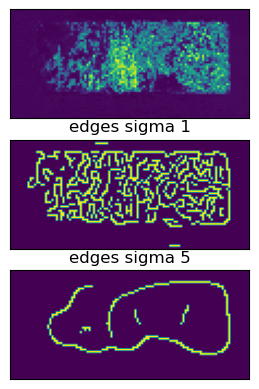

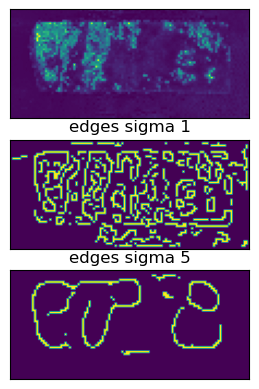

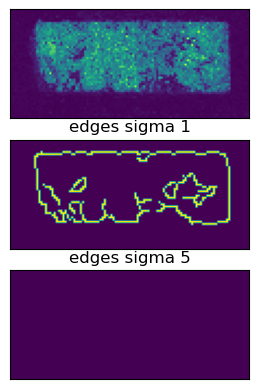

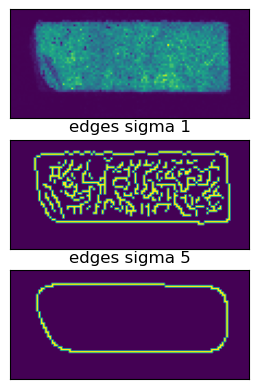

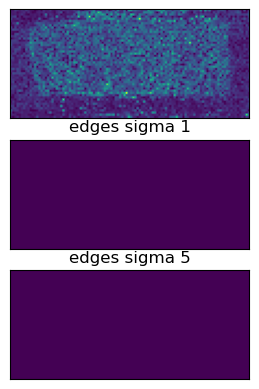

In [14]:
mask_maps=mask_t.reshape(-1,pro_data_norm.shape[0],pro_data_norm.shape[1])
elements = {
    'Li':[610.22],
    'Na':[588.99],
    'Al':[309.27],
    'Si':[288.13],
    'ruido':[799]}
element_list = list(elements.keys())

for i in element_list:
    wavenumb=elements[i]
    current_map=mask_maps[find_index(wavelengths,wavenumb),:,:]*255

    fig,ax=subplots(3)
    ax[0].imshow(current_map)

    edges1 = feature.canny(current_map,sigma=1)
    edges2 = feature.canny(current_map, sigma=5)
    ax[1].imshow(edges1)
    ax[1].set_title('edges sigma 1')

    ax[2].imshow(edges2)
    ax[2].set_title('edges sigma 5')
    for j in range(3):
        ax[j].set_xticks([])
        ax[j].set_yticks([])

    plt.show()

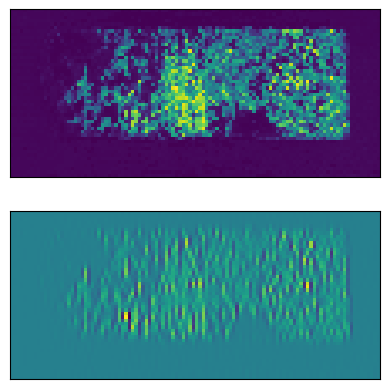

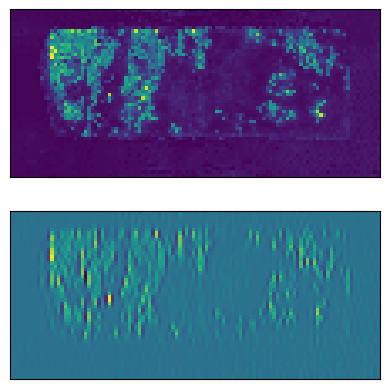

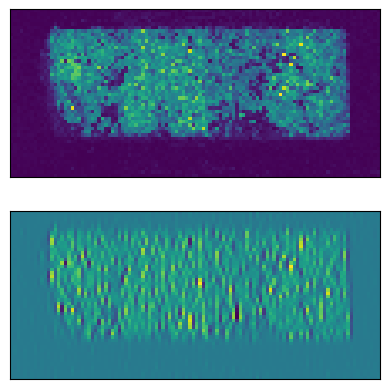

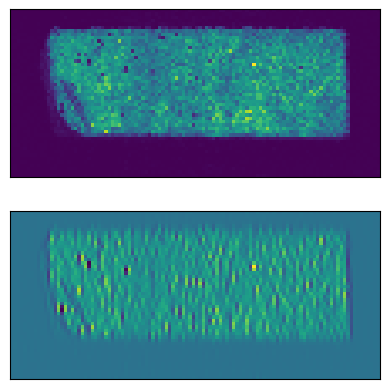

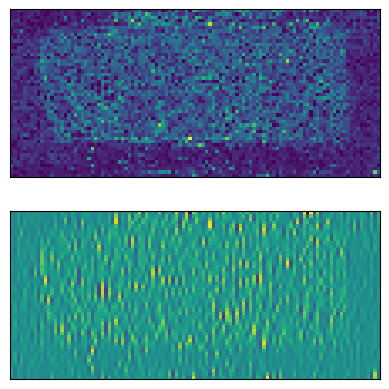

In [15]:
from skimage.filters import gabor
for i in element_list:
    wavenumb=elements[i]
    current_map=mask_maps[find_index(wavelengths,wavenumb),:,:]*255

    fig,ax=subplots(2)
    ax[0].imshow(current_map)
    filt_real, filt_imag = gabor(current_map, frequency=0.6) #lower f, more sensitivty to detail
    #f<0.6 começa a perder os detalhes dos mapas
    ax[1].imshow(filt_real)
    for j in range(2):
        ax[j].set_xticks([])
        ax[j].set_yticks([])

    plt.show()

501.16492


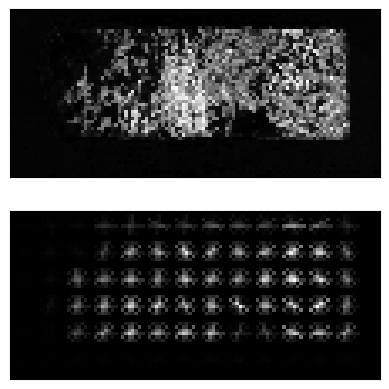

293.10553


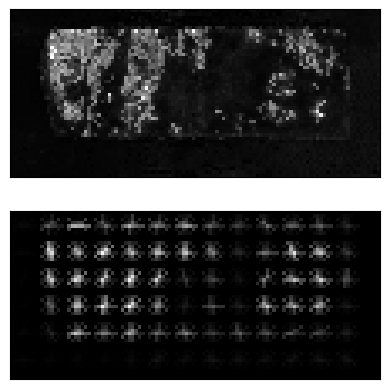

19.473898


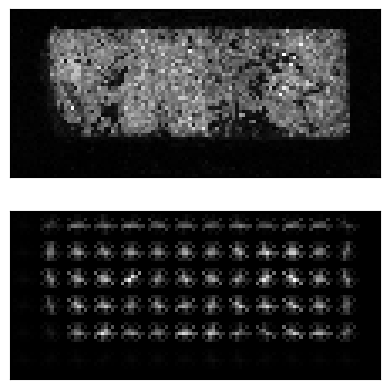

67.4552


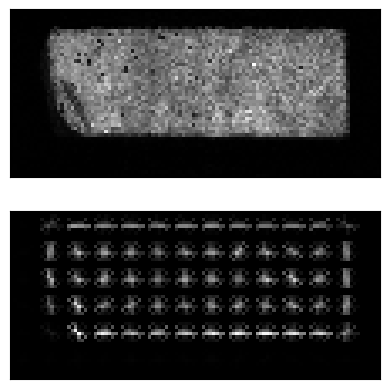

2.75149


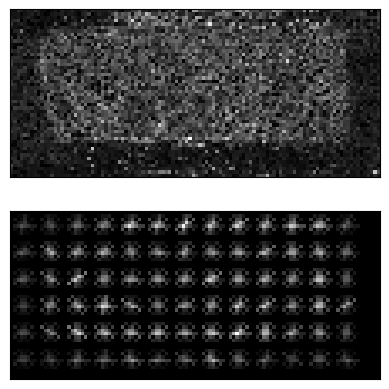

In [16]:
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

# Iterate over your mineral list
for i in element_list:
    wavenumb = elements[i]
    current_map = mask_maps[find_index(wavelengths, wavenumb), :, :] * 255

    # Compute HOG features and the HOG image
    features, hog_image = hog(
        current_map, 
        orientations=9, 
        pixels_per_cell=(8, 8), 
        cells_per_block=(2, 2), 
        block_norm='L2-Hys', 
        visualize=True, 
        feature_vector=True
    )

    # Plot the original and HOG image
    fig, ax = plt.subplots(2)
    ax[0].imshow(current_map, cmap='gray')
    ax[1].imshow(hog_image, cmap='gray')
    print(np.sum(hog_image))

    for j in range(2):
        ax[j].set_xticks([])
        ax[j].set_yticks([])

    plt.show()


In [17]:
mask_maps.shape

(16384, 50, 110)

In [19]:
maps_texture=[]
for i in tqdm(range(mask_maps.shape[0])):
    current_map=mask_maps[i]*255

    filt_real, filt_imag = gabor(current_map, frequency=0.6) #lower f, more sensitivty to detail
   
    maps_texture.append(filt_real)

maps_texture=np.array(maps_texture)


100%|██████████| 16384/16384 [00:15<00:00, 1078.10it/s]


In [20]:
somas=np.sum(maps_texture,axis=(1,2))

In [21]:
filt_imag

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

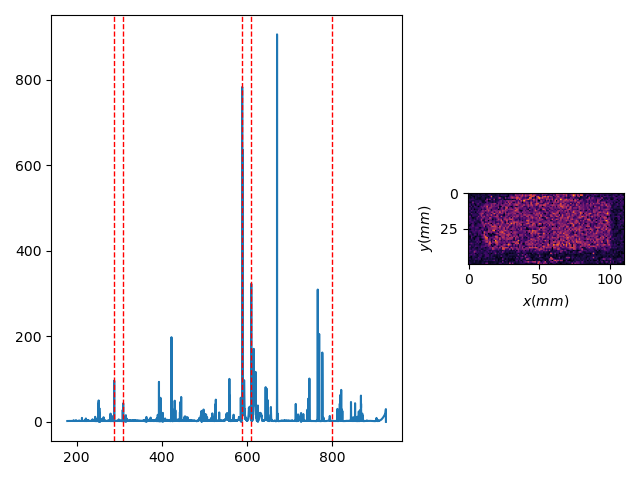

In [22]:
%matplotlib widget
fig,ax=subplots(1,2,width_ratios=[0.9,0.4])
ax[0].plot(wavelengths,somas)

axs = ax[1]
axs.imshow(mask_maps[100,:, :], cmap = cm.inferno)
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')

for i in element_list:
    ind=elements[i]
    ax[0].axvline(ind,linestyle='--',color='red',lw=1)



def update_map(wn):
    im = ax[1].imshow(mask_maps[wn,:, :], cmap = cm.inferno)

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths, ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

In [23]:
#somas acima de 50?

In [24]:
#cluster de texturas
maps_texture.shape

(16384, 50, 110)

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


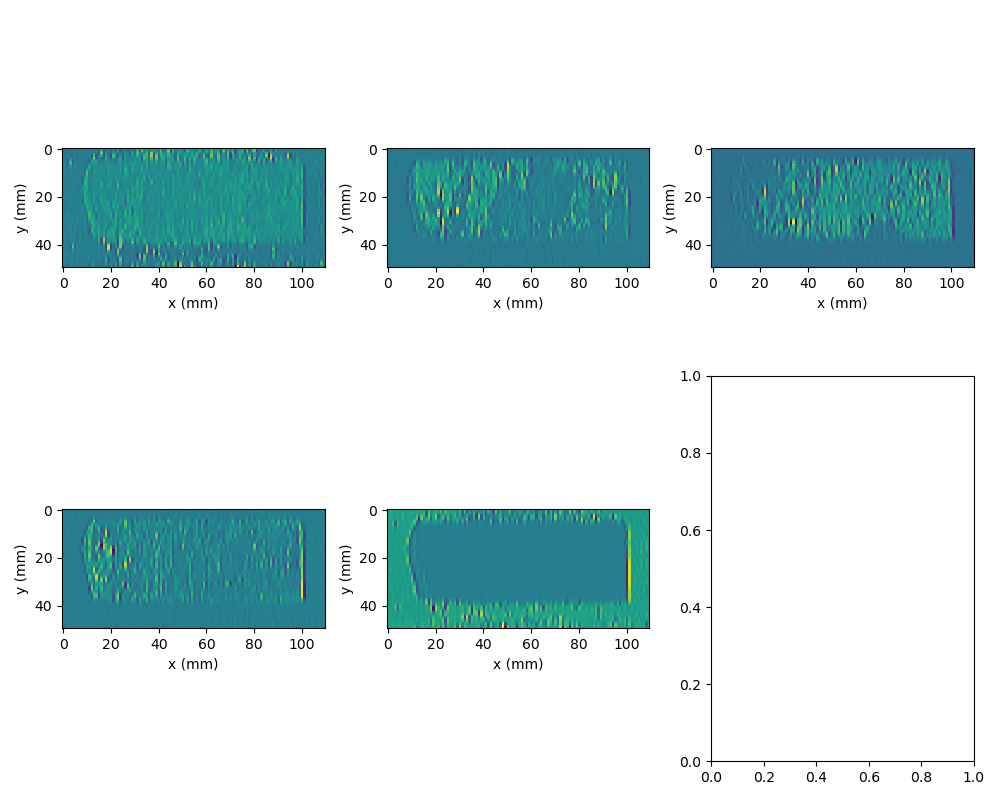

In [25]:
kmeans = sklearn.cluster.KMeans(n_clusters = 5,random_state=0)
 

features=maps_texture.reshape(-1,maps_texture.shape[1]*maps_texture.shape[2])
a=kmeans.fit_predict(features)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]), interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

In [26]:
elements

{'Li': [610.22],
 'Na': [588.99],
 'Al': [309.27],
 'Si': [288.13],
 'ruido': [799]}

In [27]:
print(mask_maps.shape)
print(maps_texture.shape)

(16384, 50, 110)
(16384, 50, 110)


In [28]:
new_features=mask_maps+maps_texture
new_features.shape

(16384, 50, 110)

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


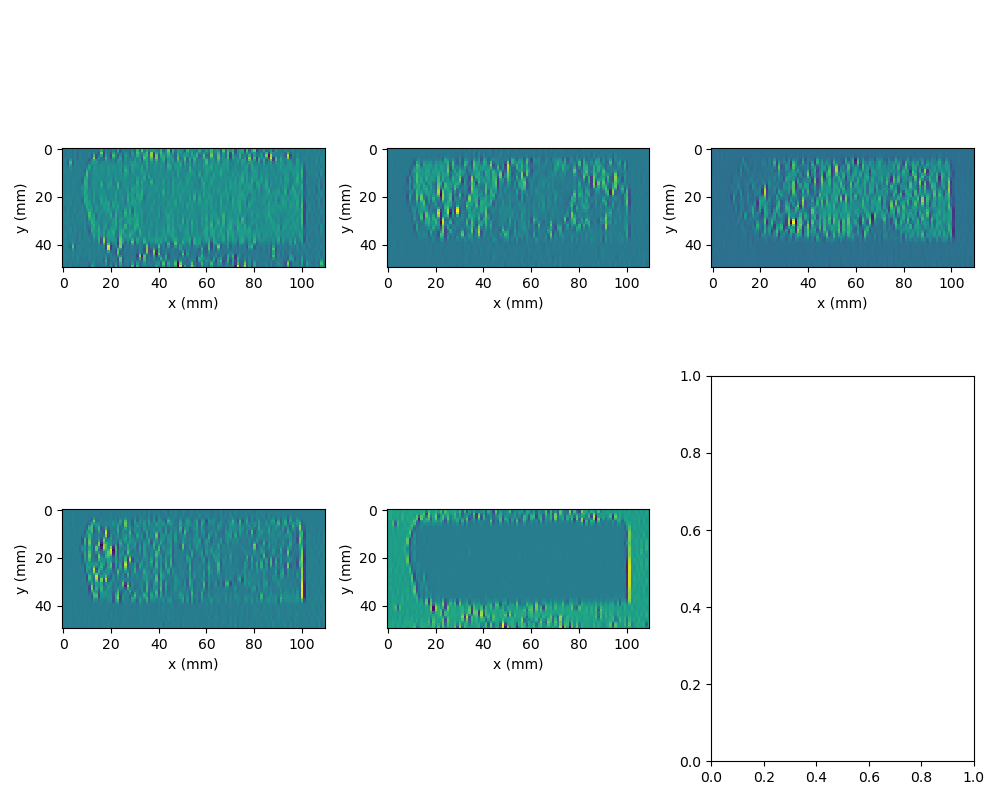

In [29]:
kmeans = sklearn.cluster.KMeans(n_clusters = 5,random_state=0)
 

features=new_features.reshape(-1,maps_texture.shape[1]*maps_texture.shape[2])
a=kmeans.fit_predict(features)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]), interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

In [30]:
edge_maps=[]
for i in tqdm(range(mask_maps.shape[0])):
    current_map=mask_maps[i,:,:]
    edges = feature.canny(current_map,sigma=1)
    edge_maps.append(edges)

edge_maps=np.array(edge_maps)



100%|██████████| 16384/16384 [00:26<00:00, 614.56it/s]


In [31]:
mask_maps.max()

0.02678398

In [32]:
new_features=mask_maps*50+edge_maps*20+maps_texture

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


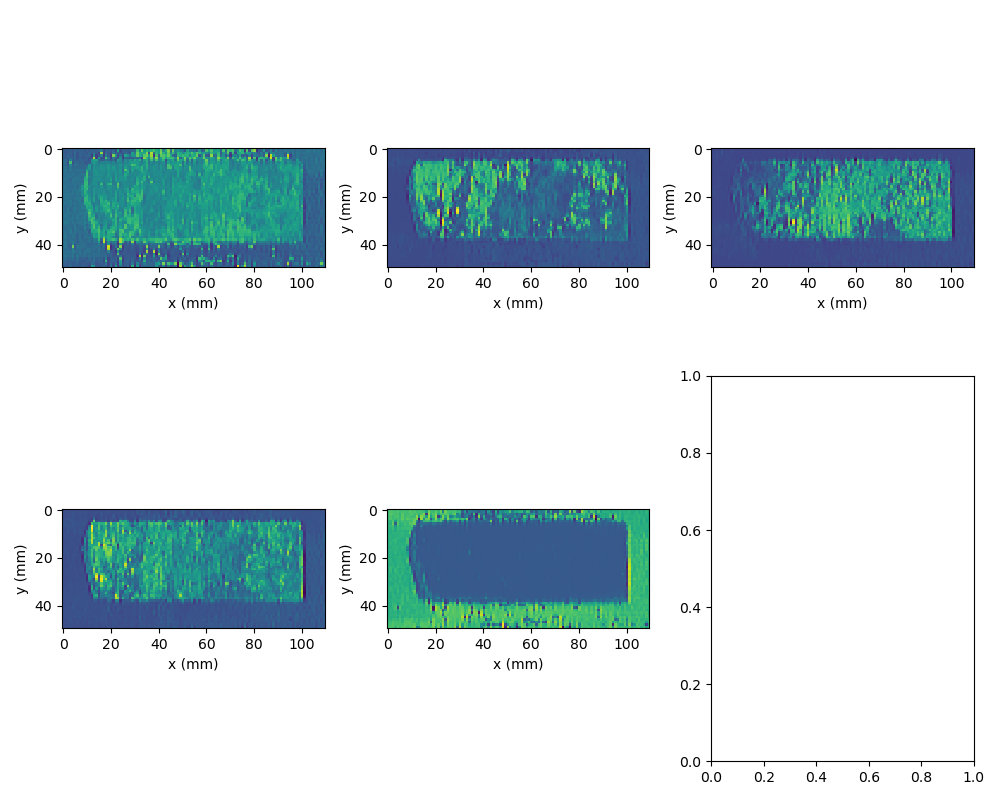

In [33]:
kmeans = sklearn.cluster.KMeans(n_clusters = 5,random_state=0)
 

features=new_features.reshape(-1,maps_texture.shape[1]*maps_texture.shape[2])
a=kmeans.fit_predict(features)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]), interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()


In [34]:
#se aumentar o peso das texturas o aluminio passa a sodio

In [35]:
# se as images dos mapas e da textura / edge tiverem intensidades diferentes estou a introduzir pesos,
#normalizar as imagens antes de somar 


## acrescentar FFT

In [36]:
new_features.shape

(16384, 50, 110)

In [37]:
# metrica fft
normalized_spec1=np.transpose(mask_t.reshape(-1,50,110),axes=(1,2,0))

nx, ny = normalized_spec1.shape[1], normalized_spec1.shape[0]
dx = 0.5
dy = 0.5
 
freqs_x = 2*np.pi*np.fft.fftfreq(nx, dx)
freqs_y = 2*np.pi*np.fft.fftfreq(ny, dy)
 
def fft_feature(mmap, pixel_size_small):
    fft_map = np.array([np.fft.fftshift(np.fft.fft2(mmap[:, :, i])) for i in tqdm(range(0, (mmap.shape[-1])))])
    fft_map[:, fft_map.shape[1]//2, fft_map.shape[2]//2] = 0
 
    kxx, kyy = np.meshgrid(np.fft.fftshift(freqs_x), np.fft.fftshift(freqs_y))
 
    object_size_small = pixel_size_small*dx
    size_kspace_small = 2*np.pi/object_size_small/2*1.5
 
    R = abs(np.sqrt(kxx**2 + kyy**2))
 
    sum1 = np.sum(np.abs(fft_map[:,(R < size_kspace_small)]), axis = (1))
    max1 = np.sum(np.abs(fft_map), axis = (1, 2))
 
    sums = np.array(sum1)/np.array(max1)
 
    return sums, fft_map
 
sums, fft_m = fft_feature(normalized_spec1, 10)

100%|██████████| 16384/16384 [00:04<00:00, 3294.06it/s]
C:\Users\Joana\AppData\Local\Temp\ipykernel_4356\4259337332.py:25: RuntimeWarning: invalid value encountered in divide
  sums = np.array(sum1)/np.array(max1)


In [38]:
sums.shape

(16384,)

In [40]:
#atribuição de pesos a cada mapa de acordo com o score da fft
new_features_fft=np.zeros(new_features.shape)
for i in tqdm(range(sums.shape[0])):
    new_features_fft[i]=new_features[i]*sums[i]

100%|██████████| 16384/16384 [00:00<00:00, 31202.43it/s]


In [57]:
np.sum(np.isnan(sums))
#sums tem nan 8x
#substituir por 0
sums = np.nan_to_num(sums, nan=0)/np.max(sums)
new_features_fft=np.zeros(new_features.shape)
for i in tqdm(range(sums.shape[0])):
    new_features_fft[i]=new_features[i]*sums[i]


100%|██████████| 16384/16384 [00:00<00:00, 24551.94it/s]


In [56]:
np.max(sums)

0.2039048230436256

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


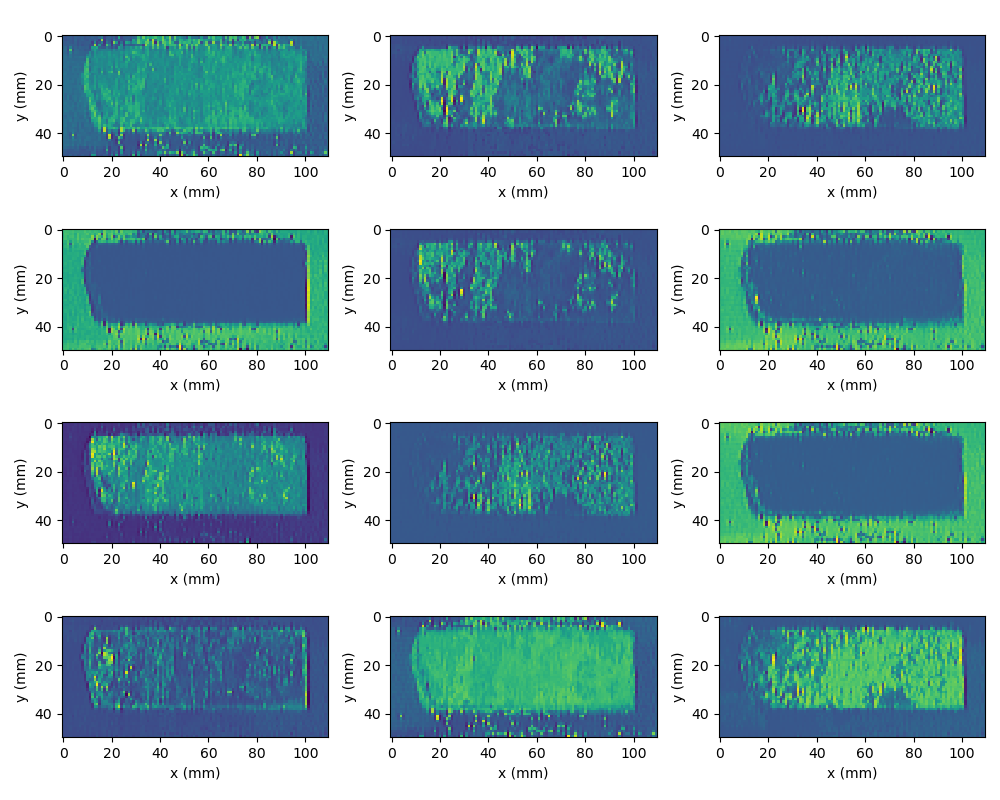

In [62]:
kmeans = sklearn.cluster.KMeans(n_clusters = 12,random_state=0)
 

features=new_features.reshape(-1,maps_texture.shape[1]*maps_texture.shape[2])
a=kmeans.fit_predict(features)
labels = kmeans.labels_
fig, ax = subplots(4, 3, figsize = (10, 8))
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]), interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()


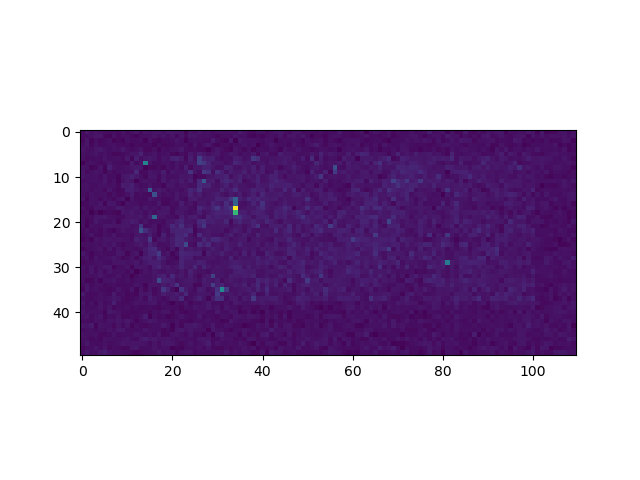

In [67]:
plt.figure()
plt.imshow(pro_data[:,:,find_index(wavelengths,259.94)])

## Concatenação das features

In [86]:
mask_maps.shape


(16384, 50, 110)

In [130]:
new_features=np.concatenate([mask_maps.reshape(-1,50*110),maps_texture.reshape(-1,50*110),edge_maps.reshape(-1,50*110)],axis=(1))

In [131]:
new_features.shape

(16384, 16500)

In [132]:
16500/3

5500.0

In [133]:
kmeans = sklearn.cluster.KMeans(n_clusters = 5,random_state=0)
 

features=new_features
a=kmeans.fit_predict(features)
labels = kmeans.labels_
clusters_c = np.array(kmeans.cluster_centers_)


c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


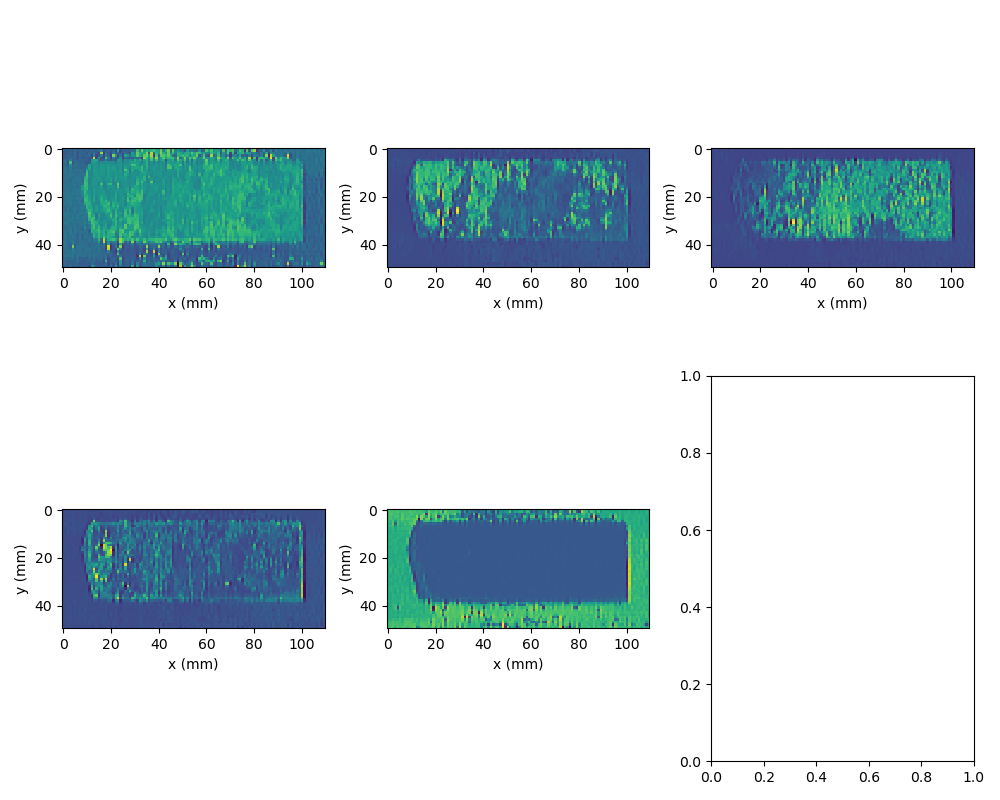

In [135]:
fig, ax = subplots(2, 3, figsize = (10, 8))
j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    axs.imshow(clusters_c[i,:5500].reshape(pro_data.shape[0], pro_data.shape[1])*50
               + clusters_c[i,5500:5500*2].reshape(pro_data.shape[0], pro_data.shape[1])
               + clusters_c[i,5500*2:].reshape(pro_data.shape[0], pro_data.shape[1])*10, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

# LIBS: FFT + thresholding + edge + texture

In [8]:
folder='C:/Users/Joana/Documents/Doutoramento/1 ano/spectral imaging/imaging_clustering/dados/'
filename = folder+"PetalideEspodumena_ADG-2-40-8_map"
#filename = "2023811_1451.h5"
#filename = "2023811_1451.h5"
def read_data_map(file):
 
    hf = h5py.File(file + '.h5', 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]
 
    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['Pro']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'])
 
   
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
   
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:, 0],positions[:, 1]))
    spectrums = spectrums[indexes, :]
    spectrums = np.array(spectrums.reshape((ny, nx, -1)))
    # print(spectrums.shape)
    positions = np.array(positions[indexes])
   
    hf.close()
    return spectrums, wavelengths, positions, unique_x, unique_y
spectrum, wavelengths, positions,unique_x,unique_y = read_data_map(filename)
wavelengths=wavelengths.flatten()

pro_data = 1*spectrum

pro_data_norm=pro_data.copy()
for i in range(0,pro_data.shape[0]):
    for j in range(0,pro_data.shape[1]):
        spec = 1 * pro_data[i,j, :]
        sum_spec=np.sum(spec)
        pro_data_norm[i,j,:]=spec/sum_spec
mask = pro_data_norm[:, :, :].reshape(pro_data.shape[0]*pro_data.shape[1], -1)
       
threshold = 1.27e-9

mask_offset = np.array(mask)
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in tqdm(range(mask_offset.shape[-1]))])

100%|██████████| 16384/16384 [00:06<00:00, 2400.26it/s]


## FFT

In [9]:
# metrica fft
normalized_spec1=np.transpose(mask_t.reshape(-1,50,110),axes=(1,2,0))

nx, ny = normalized_spec1.shape[1], normalized_spec1.shape[0]
dx = 0.5
dy = 0.5
 
freqs_x = 2*np.pi*np.fft.fftfreq(nx, dx)
freqs_y = 2*np.pi*np.fft.fftfreq(ny, dy)
 
def fft_feature(mmap, pixel_size_small):
    fft_map = np.array([np.fft.fftshift(np.fft.fft2(mmap[:, :, i])) for i in tqdm(range(0, (mmap.shape[-1])))])
    fft_map[:, fft_map.shape[1]//2, fft_map.shape[2]//2] = 0
 
    kxx, kyy = np.meshgrid(np.fft.fftshift(freqs_x), np.fft.fftshift(freqs_y))
 
    object_size_small = pixel_size_small*dx
    size_kspace_small = 2*np.pi/object_size_small/2*1.5
 
    R = abs(np.sqrt(kxx**2 + kyy**2))
 
    sum1 = np.sum(np.abs(fft_map[:,(R < size_kspace_small)]), axis = (1))
    max1 = np.sum(np.abs(fft_map), axis = (1, 2))
 
    sums = np.array(sum1)/np.array(max1)
 
    return sums, fft_map
 
sums, fft_m = fft_feature(normalized_spec1, 10)

100%|██████████| 16384/16384 [00:03<00:00, 4202.77it/s]
C:\Users\Joana\AppData\Local\Temp\ipykernel_21072\4259337332.py:25: RuntimeWarning: invalid value encountered in divide
  sums = np.array(sum1)/np.array(max1)


In [11]:
elements = {
    'Li':[610.22],
    'Na':[588.99],
    'Al':[309.27],
    'Si':[288.13],
    'ruido':[799]}
element_list = list(elements.keys())
el=[610.22,588.99,309.27,288.13]
el_n=['Li','Na','Al','Si']

In [13]:
normalized_spec1.shape

(50, 110, 16384)

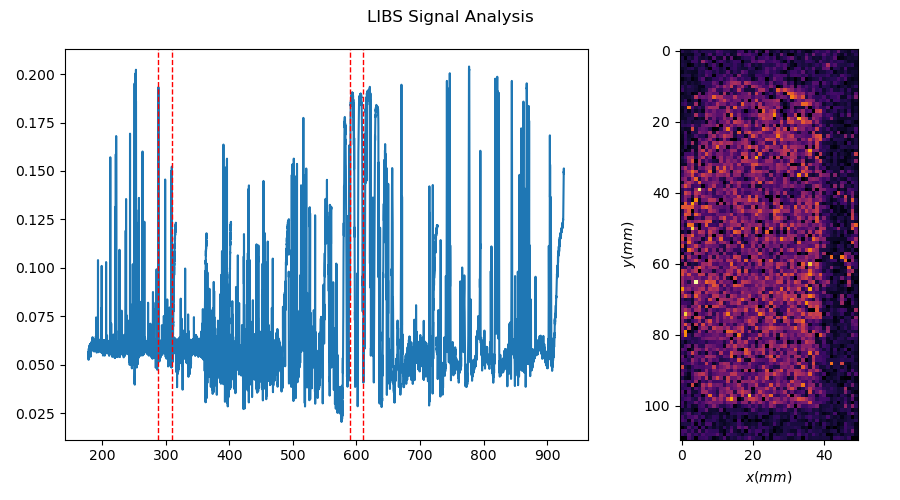

In [15]:
maps=np.transpose(normalized_spec1,axes=(2,1,0))
find_index = lambda wavelenghts,w : np.argmin(np.abs(wavelengths-w))
    
%matplotlib widget
fig, ax = subplots(1,2, figsize = (9, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('LIBS Signal Analysis')

axs = ax[0]
axs.plot(wavelengths,sums)
for i in range(len(el)):
    axs.axvline(el[i],linestyle='--',color='red',lw=1)
axs = ax[1]
axs.imshow(maps[100,:, :], cmap = cm.inferno)
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')



def update_map(wn):
    im = ax[1].imshow(maps[wn,:, :],
                     interpolation = 'none')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths, ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

In [79]:
peaks=scipy.signal.find_peaks(sums)[0]
sel_maps=[]
sel_wavs=[]
heights=sums[peaks]
for i in range(len(peaks)):
    if heights[i]>0.09:
        sel_maps.append(maps[peaks[i]])
        sel_wavs.append([wavelengths[peaks[i]]])

sel_maps=np.array(sel_maps)
sel_maps=sel_maps.reshape(-1,maps.shape[1],maps.shape[2])

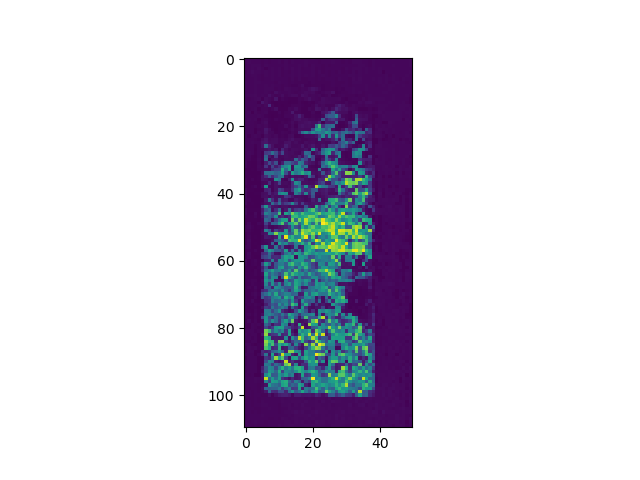

In [80]:
plt.figure()
plt.imshow(maps[find_index(wavelengths,el[0]),:])

## thresholding

In [81]:
# para os mapas que estão dentro dos parametros da fft retirar os que tem sinal fora da rocha
sel_maps_f=sel_maps.reshape(-1,sel_maps.shape[1]*sel_maps.shape[2])
thresholds=np.array([threshold_otsu(sel_maps_f[i]) for i in range(sel_maps.shape[0])])
final_masks=[]
for map in range(len(thresholds)):
    c_mask=np.zeros(sel_maps_f.shape[1])
    for i in range(sel_maps_f.shape[1]):
        if sel_maps_f[map,i]>thresholds[map]:
            c_mask[i]=1
    final_masks.append(c_mask)

final_masks=np.array(final_masks).reshape(-1,sel_maps.shape[1],sel_maps.shape[2])


new_maps=[]
edge=[]
for w in tqdm(range(sel_maps.shape[0])):
    current_map=final_masks[w,:,:]
    pixel_sum=np.sum(current_map[:,40:])
    if pixel_sum <1:
        new_maps.append(sel_maps[w,:,:])
new_maps=np.array(new_maps)
print(sel_maps.shape)
print(new_maps.shape)

100%|██████████| 706/706 [00:00<00:00, 70502.57it/s]

(706, 110, 50)
(42, 110, 50)


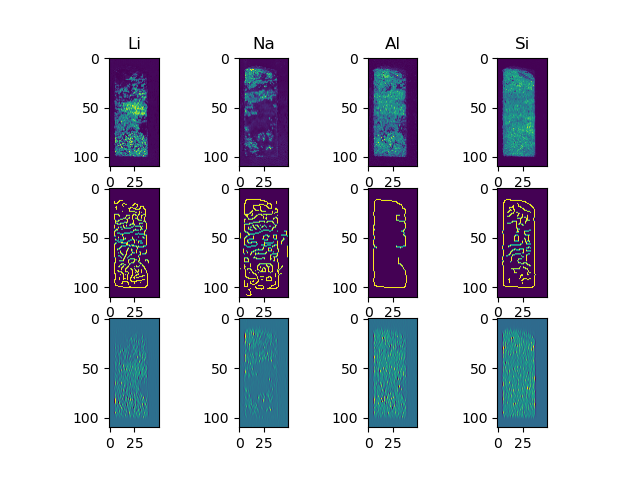

In [82]:
fig,ax=subplots(3,len(el))
for i in range(len(el)):
    c_map=maps[find_index(wavelengths,el[i]),:,:]
    ax[0,i].imshow(c_map)
    ax[0,i].set_title(el_n[i])
    ax[1,i].imshow(feature.canny(c_map*255,sigma=1.5))
    ax[2,i].imshow(gabor(c_map*255, frequency=0.6)[0])

## edge and texture

In [83]:
edge_maps=[]
for w in tqdm(range(new_maps.shape[0])):
    current_map=new_maps[w,:,:]*255
    edges = feature.canny(current_map,sigma=1.5)
    edge_maps.append(edges)
edge_maps=np.array(edge_maps)
texture_maps=[]

for w in tqdm(range(new_maps.shape[0])):
    current_map=new_maps[w,:,:]
    filt_real, filt_imag = gabor(current_map, frequency=0.6) #lower f, more sensitivty to detail
    texture_maps.append(filt_real)
texture_maps=np.array(texture_maps)

100%|██████████| 42/42 [00:00<00:00, 2524.37it/s]


## clustering

In [84]:
n_clusters=4
kmeans = sklearn.cluster.KMeans(n_clusters = n_clusters,random_state=0)
 
new_features=new_maps*500+edge_maps*0.1+texture_maps*1000
features=new_features.reshape(-1,maps.shape[1]*maps.shape[2])
a=kmeans.fit_predict(features)
labels = kmeans.labels_
clusters_c = np.array(kmeans.cluster_centers_)

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [85]:
print(np.mean(new_maps))
print(np.mean(edge_maps))
print(np.mean(texture_maps))

0.0010706984
0.05856277056277056
6.908406e-05


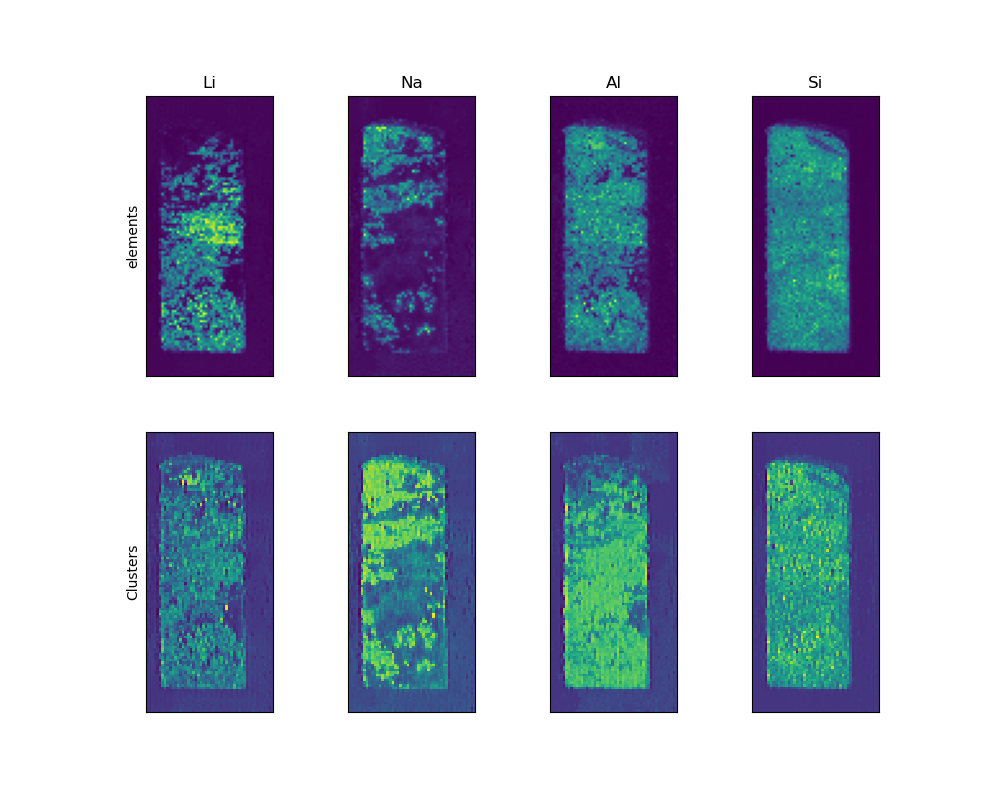

In [87]:
fig,ax=subplots(2,n_clusters,figsize=(10,8))
for i in range(n_clusters):
    if i<len(el):
        wav=find_index(wavelengths,el[i])
        ax[0,i].imshow(maps[wav,:,:])
        ax[0,i].set_title(el_n[i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[0,0].set_ylabel('elements')
    ax[1,0].set_ylabel('Clusters')

    ax[1,i].imshow(clusters_c[i].reshape(maps.shape[1], maps.shape[2]), interpolation = 'none')
    savefig('clustering_results_petalite_espodumeno.jpg',dpi=400)

# LIBS: FFT + thresholding + edge + texture HDR

In [94]:
file='C:/Users/Joana/Documents/Doutoramento/1 ano/spectral imaging/HDR/Comparação libs_raman/hdr_petalite_espodumeno.h5'
def read_data_map_2(file):
    # Open the HDF5 file in read mode
    with h5py.File(file, 'r') as hf:
        # Extract the datasets and convert them to numpy arrays
        spectrums = np.array(hf.get('intensities'))
        positions = np.array(hf.get('position'))
        wavelengths = np.array(hf.get('wavelengths'))

    # Return the data as is
    return spectrums, wavelengths, positions
spectrum, wavelengths, positions = read_data_map_2(file)

In [96]:
print(spectrum.shape)
print(wavelengths.shape)

(16384, 50, 110)
(16384,)


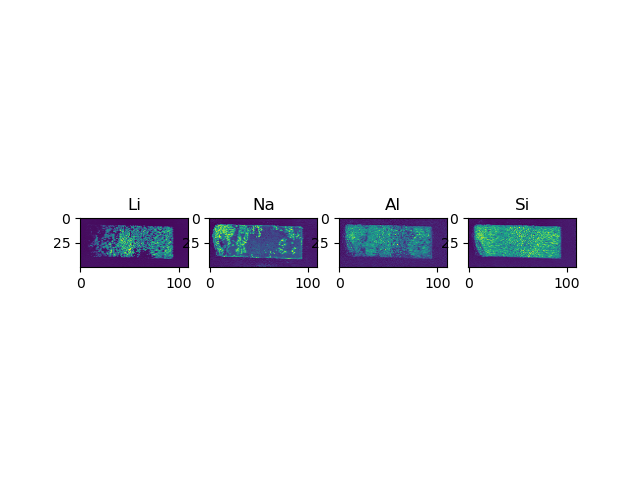

In [90]:
maps=spectrum.copy()
fig,ax=subplots(1,len(el))
for i in range(len(el)):
    ax[i].imshow(maps[find_index(wavelengths,el[i]),:,:])
    ax[i].set_title(el_n[i])

In [97]:
maps.shape

(16384, 50, 110)

In [98]:
normalized_spec1=np.transpose(maps.reshape(-1,maps.shape[1],maps.shape[2]),axes=(1,2,0))

nx, ny = normalized_spec1.shape[1], normalized_spec1.shape[0]
dx = 0.5
dy = 0.5
 
freqs_x = 2*np.pi*np.fft.fftfreq(nx, dx)
freqs_y = 2*np.pi*np.fft.fftfreq(ny, dy)
 
def fft_feature(mmap, pixel_size_small):
    fft_map = np.array([np.fft.fftshift(np.fft.fft2(mmap[:, :, i])) for i in tqdm(range(0, (mmap.shape[-1])))])
    fft_map[:, fft_map.shape[1]//2, fft_map.shape[2]//2] = 0
 
    kxx, kyy = np.meshgrid(np.fft.fftshift(freqs_x), np.fft.fftshift(freqs_y))
 
    object_size_small = pixel_size_small*dx
    size_kspace_small = 2*np.pi/object_size_small/2*1.5
 
    R = abs(np.sqrt(kxx**2 + kyy**2))
 
    sum1 = np.sum(np.abs(fft_map[:,(R < size_kspace_small)]), axis = (1))
    max1 = np.sum(np.abs(fft_map), axis = (1, 2))
 
    sums = np.array(sum1)/np.array(max1)
 
    return sums, fft_map
 
sums, fft_m = fft_feature(normalized_spec1, 10)

100%|██████████| 16384/16384 [00:06<00:00, 2465.44it/s]


In [99]:
wavelengths.shape

(16384,)

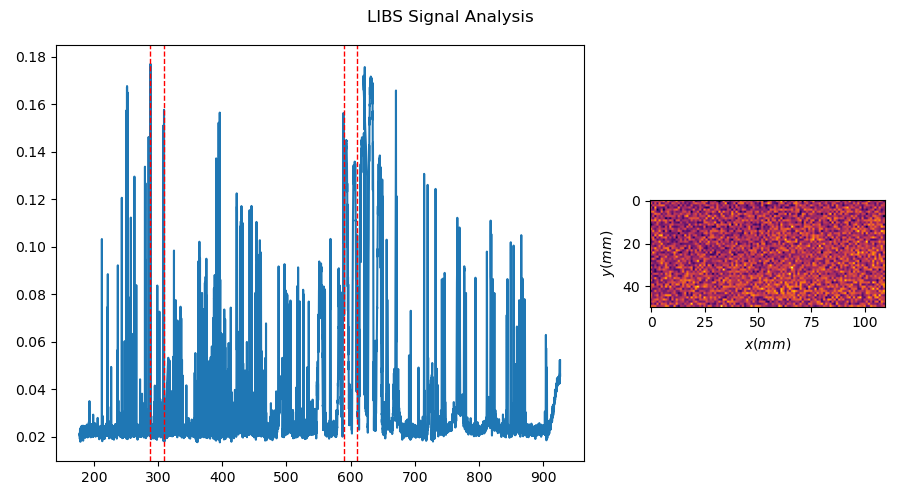

In [102]:

find_index = lambda wavelenghts,w : np.argmin(np.abs(wavelengths-w))
    
%matplotlib widget
fig, ax = subplots(1,2, figsize = (9, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('LIBS Signal Analysis')

axs = ax[0]
axs.plot(wavelengths,sums)
for i in range(len(el)):
    axs.axvline(el[i],linestyle='--',color='red',lw=1)
axs = ax[1]
axs.imshow(maps[100,:, :], cmap = cm.inferno)
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')



def update_map(wn):
    im = ax[1].imshow(maps[wn,:, :],
                     interpolation = 'none')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths, ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

In [218]:
peaks=scipy.signal.find_peaks(sums)[0]
sel_maps=[]
sel_wavs=[]
heights=sums[peaks]
for i in range(len(peaks)):
    if heights[i]>0.11:
        sel_maps.append(maps[peaks[i]])
        sel_wavs.append([wavelengths[peaks[i]]])

sel_maps=np.array(sel_maps)
sel_maps=sel_maps.reshape(-1,maps.shape[1],maps.shape[2])

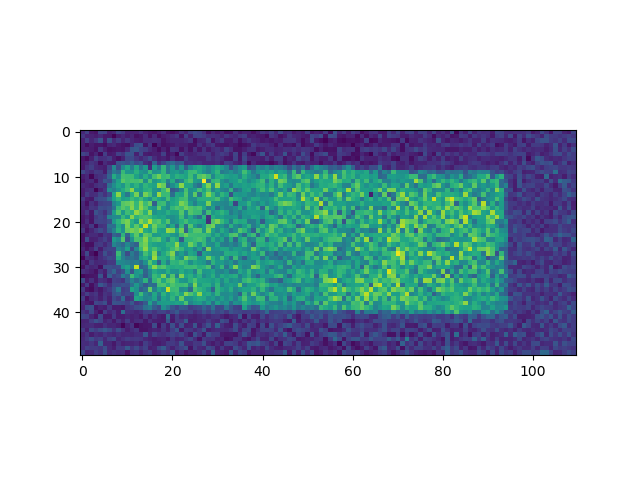

In [219]:
plt.figure()
plt.imshow(sel_maps[2,:,:])

In [220]:
# para os mapas que estão dentro dos parametros da fft retirar os que tem sinal fora da rocha
sel_maps_f=sel_maps.reshape(-1,sel_maps.shape[1]*sel_maps.shape[2])
thresholds=np.array([threshold_otsu(sel_maps_f[i]) for i in range(sel_maps.shape[0])])
final_masks=[]
for map in range(len(thresholds)):
    c_mask=np.zeros(sel_maps_f.shape[1])
    for i in range(sel_maps_f.shape[1]):
        if sel_maps_f[map,i]>thresholds[map]:
            c_mask[i]=1
    final_masks.append(c_mask)

final_masks=np.array(final_masks).reshape(-1,sel_maps.shape[1],sel_maps.shape[2])


new_maps=[]
edge=[]
for w in tqdm(range(final_masks.shape[0])):
    current_map=final_masks[w,:,:]
    pixel_sum=np.sum(current_map[43:,:])
    if pixel_sum <1:
        new_maps.append(sel_maps[w,:,:])
new_maps=np.array(new_maps)
print(sel_maps.shape)
print(new_maps.shape)

100%|██████████| 180/180 [00:00<00:00, 60004.35it/s]

(180, 50, 110)
(22, 50, 110)


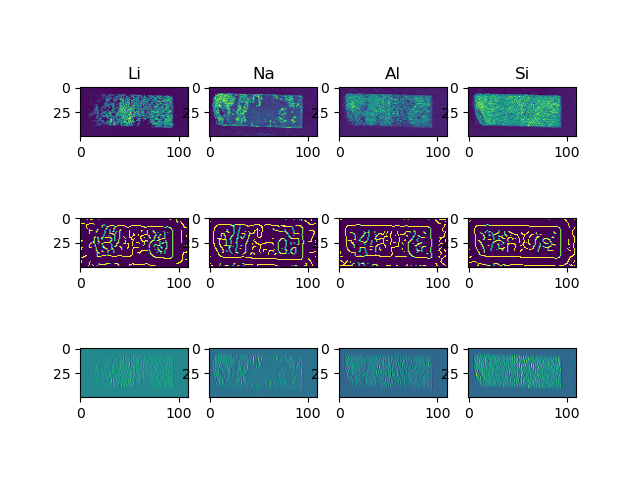

In [221]:
fig,ax=subplots(3,len(el))
for i in range(len(el)):
    c_map=maps[find_index(wavelengths,el[i]),:,:]
    ax[0,i].imshow(c_map)
    ax[0,i].set_title(el_n[i])
    ax[1,i].imshow(feature.canny(c_map*255,sigma=2))
    ax[2,i].imshow(gabor(c_map*255, frequency=0.6)[0])

In [222]:
edge_maps=[]
for w in tqdm(range(new_maps.shape[0])):
    current_map=new_maps[w,:,:]*255
    edges = feature.canny(current_map,sigma=1.5)
    edge_maps.append(edges)
edge_maps=np.array(edge_maps)
texture_maps=[]

for w in tqdm(range(new_maps.shape[0])):
    current_map=new_maps[w,:,:]
    filt_real, filt_imag = gabor(current_map, frequency=0.6) #lower f, more sensitivty to detail
    texture_maps.append(filt_real)
texture_maps=np.array(texture_maps)


100%|██████████| 22/22 [00:00<00:00, 1293.45it/s]


In [223]:
print(np.mean(edge_maps))
print(np.mean(sel_maps))
print(np.mean(texture_maps))

0.19705785123966943
0.18038732051645337
0.011807411476600256


In [255]:
n_clusters=4
kmeans = sklearn.cluster.KMeans(n_clusters = n_clusters,random_state=0)
 
new_features=new_maps*500+edge_maps*10+texture_maps*400
features=new_features.reshape(-1,maps.shape[2]*maps.shape[1])
a=kmeans.fit_predict(features)
labels = kmeans.labels_
clusters_c = np.array(kmeans.cluster_centers_)

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [256]:
el

[610.22, 588.99, 309.27, 288.13]

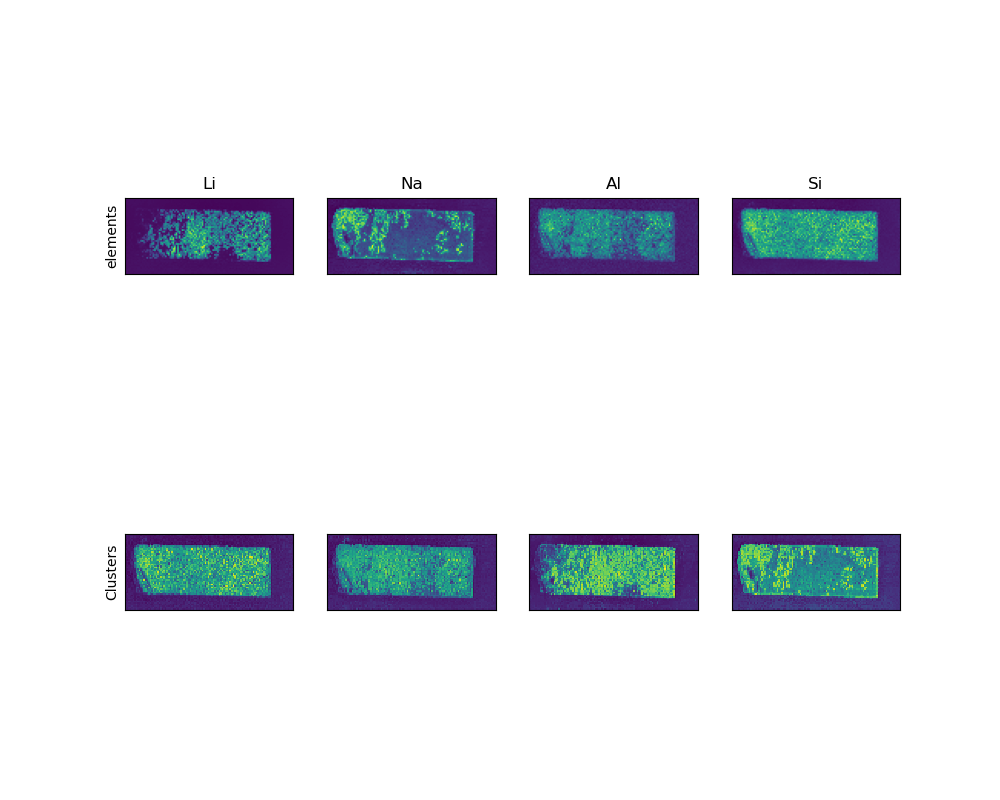

In [257]:
fig,ax=subplots(2,n_clusters,figsize=(10,8))
for i in range(n_clusters):
    if i<len(el):
        wav=find_index(wavelengths,el[i])
        ax[0,i].imshow(maps[wav,:,:])
        ax[0,i].set_title(el_n[i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[0,0].set_ylabel('elements')
    ax[1,0].set_ylabel('Clusters')

    ax[1,i].imshow(clusters_c[i].reshape(maps.shape[1], maps.shape[2]), interpolation = 'none')

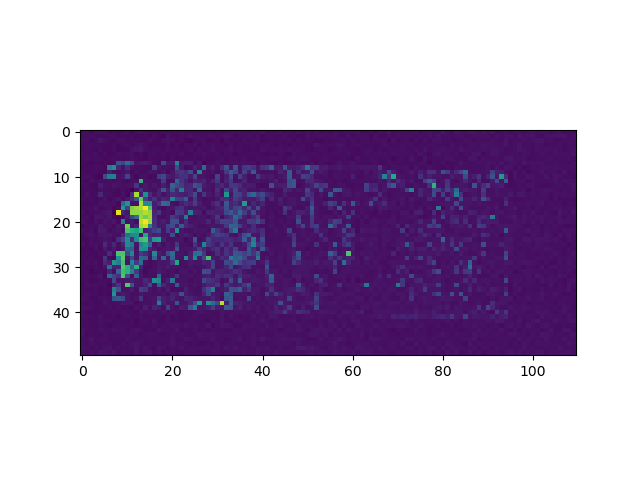

In [258]:
plt.figure()
plt.imshow(maps[find_index(wavelengths,779.94)])